In [1]:
import sys

import pandas as pd
import sklearn as sk
import tensorflow as tf
import keras
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.0-arm64-arm-64bit
Tensor Flow Version: 2.13.0
Keras Version: 2.13.1

Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
Pandas 2.1.0
Scikit-Learn 1.3.0
GPU is available


In [2]:
%load_ext autoreload
%autoreload 2

# from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability as tfp

# import aequitas as ae
pd.set_option('display.max_columns', 500)

# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [129]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,NaN,NaN,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,NaN,NaN,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,NaN,NaN,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,NaN,NaN,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,NaN,NaN,Ch,NO


## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [5]:
try:
    assert(df.encounter_id.nunique() < df.shape[0])
    print("Data is most likely at the line level")
except:
    print("Data is most likely not the line level")

Data is most likely at the line level


In [6]:
df.sort_values(by=["patient_nbr", "encounter_id"]).head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
5675,24437208,135,Caucasian,Female,[50-60),?,2,1,1,8,?,Cardiology,401,997|560,0,0,0,77,8,33,6,42291-559,NaN,NaN,Ch,<30
5676,24437208,135,Caucasian,Female,[50-60),?,2,1,1,8,?,Cardiology,401,997|560,0,0,0,77,8,33,6,0093-9364,NaN,NaN,Ch,<30
5677,24437208,135,Caucasian,Female,[50-60),?,2,1,1,8,?,Cardiology,401,997|560,0,0,0,77,8,33,6,68071-1701,NaN,NaN,Ch,<30
6337,26264286,135,Caucasian,Female,[50-60),?,1,1,7,3,?,Surgery-Cardiovascular/Thoracic,998,41|250,0,1,0,31,5,14,1,0087-6070,NaN,NaN,Ch,>30
6338,26264286,135,Caucasian,Female,[50-60),?,1,1,7,3,?,Surgery-Cardiovascular/Thoracic,998,41|250,0,1,0,31,5,14,1,0093-9477,NaN,NaN,Ch,>30


**Response**

We can see from the above dataframe that for the same patient number `135`, and the same encounter ID `24437208`, we have three rows with a different NDC code for each of the three rows.

-->  **The Dataset is at the line level.**

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


### a. Columns with high amount of missing values

In [7]:
df.replace("NaN", np.nan, inplace=True)
df.replace("?", np.nan, inplace=True)
df.replace("Unknown/Invalid", np.nan, inplace=True)

Some columns still have question marks along with other caracters. In the following cell we try to find these records.

In [8]:
l = []
for col in df.columns:
    l.append(df[df[col].astype(str).str.contains("\?")].copy())

df_null = pd.concat(l, axis=0)

In [9]:
df_null

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,NaN,NaN,No,NO
96,715086,3376278,Caucasian,Male,[10-20),NaN,1,5,7,1,NaN,NaN,250.11,?|?,0,0,0,51,1,4,0,68071-1701,NaN,NaN,Ch,NO
256,2595612,89193870,Caucasian,Female,[40-50),NaN,6,1,7,2,NaN,NaN,250.02,401|?,0,0,0,53,2,4,0,NaN,>300,>8,No,>30
259,2600796,1451637,Caucasian,Female,[20-30),NaN,6,25,7,1,NaN,Family/GeneralPractice,493,250|?,0,0,0,66,2,6,0,0378-7185,NaN,NaN,No,>30
285,2735964,2359485,Caucasian,Female,[0-10),NaN,6,25,7,3,NaN,Pediatrics-Endocrinology,250.03,?|?,0,0,0,34,1,4,0,47918-902,NaN,>8,No,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142732,437309498,52653654,Caucasian,Male,[60-70),[100-125),1,1,7,7,BC,Surgery-General,552,250|?,1,0,0,54,2,14,4,0093-7212,NaN,NaN,No,NO
143008,439709132,109758042,Hispanic,Male,[50-60),NaN,2,1,7,1,SP,Surgery-General,786,250|?,0,0,1,4,2,7,3,0173-0861,NaN,Norm,No,NO
143127,440879552,42751098,Caucasian,Female,[60-70),NaN,3,1,1,5,MC,Nephrology,590,276|?,0,0,0,42,8,15,1,0049-4110,NaN,NaN,Ch,NO
143128,440879552,42751098,Caucasian,Female,[60-70),NaN,3,1,1,5,MC,Nephrology,590,276|?,0,0,0,42,8,15,1,68071-1701,NaN,NaN,Ch,NO


The colum `other_diagnosis_codes` still have some question marks. It also happends that we have one code along with a question mark. Let's see how many records have no `other_diagnosis_code` at all.

In [10]:
df[df.other_diagnosis_codes.astype(str).str.contains("\?")]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,NaN,NaN,No,NO
96,715086,3376278,Caucasian,Male,[10-20),NaN,1,5,7,1,NaN,NaN,250.11,?|?,0,0,0,51,1,4,0,68071-1701,NaN,NaN,Ch,NO
256,2595612,89193870,Caucasian,Female,[40-50),NaN,6,1,7,2,NaN,NaN,250.02,401|?,0,0,0,53,2,4,0,NaN,>300,>8,No,>30
259,2600796,1451637,Caucasian,Female,[20-30),NaN,6,25,7,1,NaN,Family/GeneralPractice,493,250|?,0,0,0,66,2,6,0,0378-7185,NaN,NaN,No,>30
285,2735964,2359485,Caucasian,Female,[0-10),NaN,6,25,7,3,NaN,Pediatrics-Endocrinology,250.03,?|?,0,0,0,34,1,4,0,47918-902,NaN,>8,No,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142732,437309498,52653654,Caucasian,Male,[60-70),[100-125),1,1,7,7,BC,Surgery-General,552,250|?,1,0,0,54,2,14,4,0093-7212,NaN,NaN,No,NO
143008,439709132,109758042,Hispanic,Male,[50-60),NaN,2,1,7,1,SP,Surgery-General,786,250|?,0,0,1,4,2,7,3,0173-0861,NaN,Norm,No,NO
143127,440879552,42751098,Caucasian,Female,[60-70),NaN,3,1,1,5,MC,Nephrology,590,276|?,0,0,0,42,8,15,1,0049-4110,NaN,NaN,Ch,NO
143128,440879552,42751098,Caucasian,Female,[60-70),NaN,3,1,1,5,MC,Nephrology,590,276|?,0,0,0,42,8,15,1,68071-1701,NaN,NaN,Ch,NO


In [11]:
df[df.other_diagnosis_codes.str.contains("\?\|\?")]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,NaN,NaN,No,NO
96,715086,3376278,Caucasian,Male,[10-20),NaN,1,5,7,1,NaN,NaN,250.11,?|?,0,0,0,51,1,4,0,68071-1701,NaN,NaN,Ch,NO
285,2735964,2359485,Caucasian,Female,[0-10),NaN,6,25,7,3,NaN,Pediatrics-Endocrinology,250.03,?|?,0,0,0,34,1,4,0,47918-902,NaN,>8,No,NO
344,2948334,3425292,AfricanAmerican,Female,[30-40),NaN,6,25,1,2,NaN,InternalMedicine,250.8,?|?,0,0,0,36,1,2,0,NaN,NaN,NaN,No,NO
555,3902532,4893183,AfricanAmerican,Female,[20-30),NaN,6,25,7,2,NaN,InternalMedicine,250.13,?|?,0,0,0,63,1,5,0,47918-902,NaN,>8,Ch,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132244,341359292,43520868,Caucasian,Female,[90-100),NaN,1,14,7,1,MC,NaN,584,?|?,0,1,0,36,7,6,0,NaN,NaN,NaN,No,NO
134067,357840194,99015219,Caucasian,Male,[60-70),NaN,3,1,1,1,NaN,Cardiology,250.02,?|?,1,0,0,48,1,5,0,NaN,NaN,>8,No,>30
136081,377226950,24145722,Caucasian,Female,[10-20),[25-50),2,7,1,1,UN,Pediatrics,250.13,?|?,0,0,0,32,1,3,0,NaN,NaN,>8,No,NO
142044,430828958,146717159,Caucasian,Female,[0-10),NaN,3,1,1,3,BC,NaN,250.01,?|?,0,0,0,2,1,2,0,50090-0353,NaN,>8,No,NO


-> 340 records have no `other_diagnosis_codes` at all. This means 1644 recors have one additional code.

Let's replace the empty one with null values.

In [12]:
df.replace("?|?", np.nan, inplace=True)

#### Order columns by missing values / zeros percentage

In [13]:
def check_null_values(df):
    null_df = pd.DataFrame({ 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                            'percent_zero': df.isin([0]).sum() * 100 / len(df)
                           } )
    return null_df

In [14]:
df_check = check_null_values(df)
df_check.sort_values(by="percent_null", ascending=False)

,percent_null,percent_zero
weight,97.000502,0.000000
max_glu_serum,95.108908,0.000000
A1Cresult,82.029507,0.000000
medical_specialty,48.431922,0.000000
payer_code,37.783077,0.000000
ndc_code,16.358490,0.000000
race,2.307145,0.000000
other_diagnosis_codes,0.237059,0.000000
primary_diagnosis_code,0.023009,0.000000
gender,0.003486,0.000000


In [15]:
df_check.sort_values(by="percent_zero", ascending=False)

,percent_null,percent_zero
number_emergency,0.000000,88.858211
number_outpatient,0.000000,83.686831
number_inpatient,0.000000,67.421073
num_procedures,0.000000,45.869589
encounter_id,0.000000,0.000000
patient_nbr,0.000000,0.000000
change,0.000000,0.000000
A1Cresult,82.029507,0.000000
max_glu_serum,95.108908,0.000000
ndc_code,16.358490,0.000000


### b. Value Distributions

In [16]:
continuous_cols = ["time_in_hospital", "num_lab_procedures", "num_medications"]

/Users/rachidaseghiri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rachidaseghiri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rachidaseghiri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


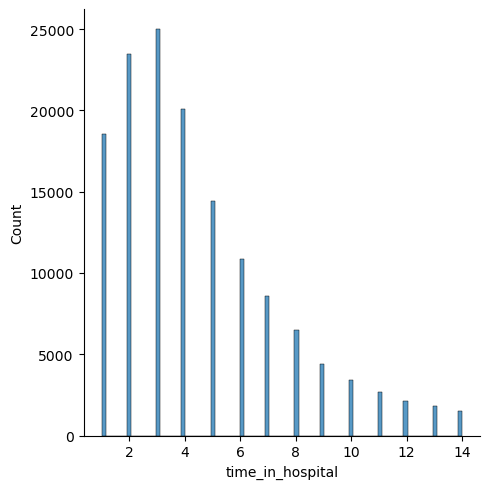

In [144]:
sns.displot(df.time_in_hospital)
plt.show()

/Users/rachidaseghiri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rachidaseghiri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rachidaseghiri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


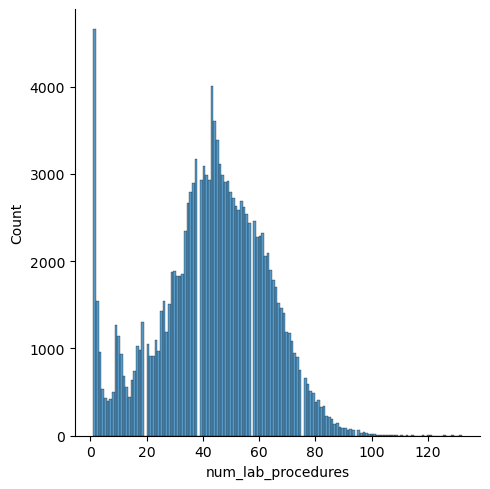

In [145]:
sns.displot(df.num_lab_procedures)
plt.show()

/Users/rachidaseghiri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rachidaseghiri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rachidaseghiri/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


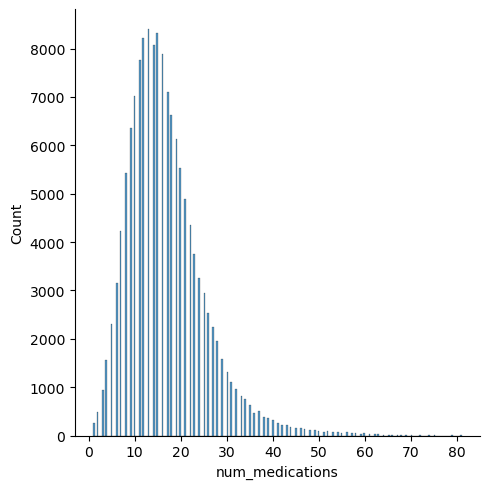

In [146]:
sns.displot(df.num_medications)

<Axes: xlabel='age'>

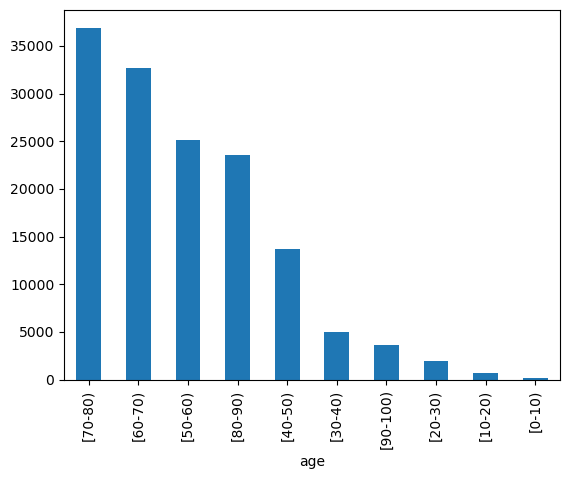

In [147]:
df.age.value_counts().plot(kind="bar")

#### c. Cardinality

In [17]:
cat_cols = ['race', 'gender', 'age', 
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency',
       'number_diagnoses', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted']

In [18]:
pd.DataFrame({"cardinality": df[cat_cols].nunique()}).sort_values("cardinality", ascending=False)

,cardinality
other_diagnosis_codes,19373
primary_diagnosis_code,716
ndc_code,251
medical_specialty,72
number_outpatient,39
number_emergency,33
discharge_disposition_id,26
number_inpatient,21
admission_source_id,17
payer_code,17


#### d. Demographic Distribution

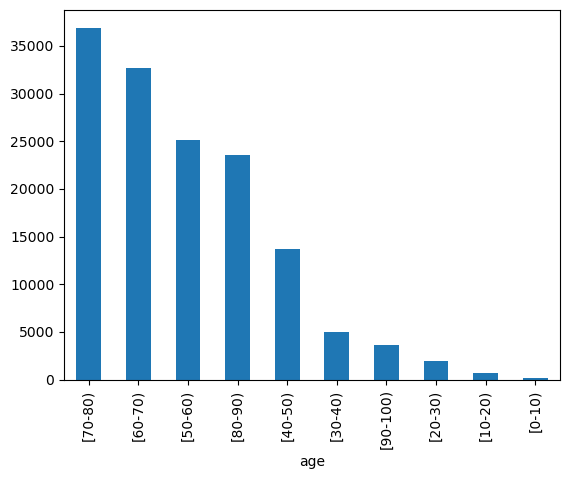

In [150]:
df.age.value_counts().plot(kind="bar")
plt.show()

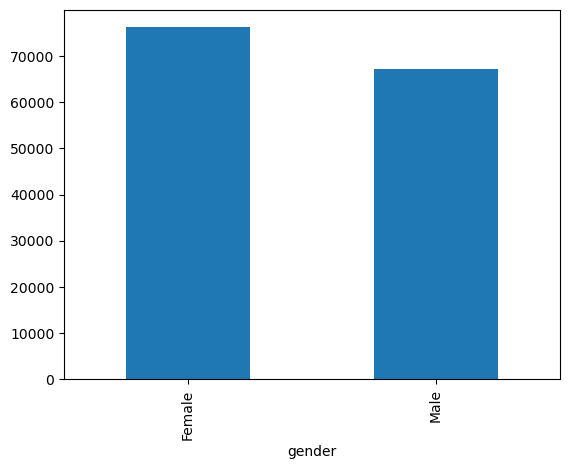

In [151]:
df.gender.value_counts().plot(kind='bar')
plt.show()

In [152]:
df.gender.value_counts()

gender
Female    76185
Male      67234
Name: count, dtype: int64

**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: ??

In [153]:
######NOTE: The visualization will only display in Chrome browser. ########
# full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
# tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [19]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [20]:
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [21]:
# remove spaces from Non-proprietary Name column
# this avoids problems with tensorflow during training
ndc_code_df["Non-proprietary Name"] = ndc_code_df["Non-proprietary Name"].str.replace(" ", "_")

In [22]:
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin_Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin_Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin_Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin_Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin_Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [24]:
from student_utils import reduce_dimension_ndc
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)


In [160]:
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,NaN,0,0,0,41,1,1,0,NaN,NaN,NaN,No,NO,NaN,NaN
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,NaN,NaN,Ch,>30,68071-1701,Human_Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,NaN,NaN,No,NO,0378-1110,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,NaN,NaN,Ch,NO,68071-1701,Human_Insulin
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,NaN,NaN,Ch,NO,0049-4110,Glipizide


In [25]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [26]:
reduce_dim_df['generic_drug_name'].nunique()

22

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [27]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [28]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [30]:
from utils import aggregate_dataset

exclusion_list = ['generic_drug_name', "NDC_Code", "ndc_code"]
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/Users/rachidaseghiri/Documents/healthcare_ai/patient-selection-for-diabetes-drug-test/starter_code/utils.py:21: FutureWarning: The provided callable <built-in function max> is currently using np.maximum.reduce. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass np.maximum.reduce instead.
  .apply(max)


In [31]:
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Glyburide_And_Metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,NaN,0,0,0,41,1,1,0,NaN,NaN,No,NO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,NaN,NaN,Ch,>30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,NaN,NaN,No,NO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,NaN,NaN,Ch,NO,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,NaN,NaN,Ch,NO,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
test = 443857166
first_encounter_df[first_encounter_df.encounter_id == test][["encounter_id", "generic_drug_name"]]

,encounter_id,generic_drug_name
143478,443857166,Glipizide
143479,443857166,Pioglitazone
143480,443857166,Insulin_Human


In [33]:
agg_drug_df[agg_drug_df.encounter_id == test]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Glyburide_And_Metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
71516,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,NaN,NaN,Ch,NO,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [34]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response:

- We exclude the payer_code because the insurance paying for the company shouldn't have an impact on the number of hospitalization days.

- The weight feature is mostly null. For this reason we will also exclude it from the dataset.

In [35]:
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Glyburide_And_Metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,NaN,0,0,0,41,1,1,0,NaN,NaN,No,NO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,NaN,NaN,Ch,>30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,NaN,NaN,No,NO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,NaN,NaN,Ch,NO,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,NaN,NaN,Ch,NO,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [171]:
agg_drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71518 entries, 0 to 71517
Data columns (total 46 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   encounter_id                                71518 non-null  int64 
 1   patient_nbr                                 71518 non-null  int64 
 2   race                                        69640 non-null  object
 3   gender                                      71515 non-null  object
 4   age                                         71518 non-null  object
 5   weight                                      2847 non-null   object
 6   admission_type_id                           71518 non-null  int64 
 7   discharge_disposition_id                    71518 non-null  int64 
 8   admission_source_id                         71518 non-null  int64 
 9   time_in_hospital                            71518 non-null  int64 
 10  payer_code            

In [172]:
numerical = [col for col in df.columns if df[col].dtype == "int64"]
categorical = list(set(list(df.columns)).difference(set(numerical)))
categorical.remove("ndc_code")

In [173]:
agg_drug_df[categorical].isna().sum() / agg_drug_df.shape[0]

medical_specialty         0.482746
max_glu_serum             0.951383
primary_diagnosis_code    0.000238
payer_code                0.420663
readmitted                0.000000
gender                    0.000042
age                       0.000000
A1Cresult                 0.826645
race                      0.026259
change                    0.000000
other_diagnosis_codes     0.003384
weight                    0.960192
dtype: float64

In [174]:
agg_drug_df[numerical].isna().sum() / agg_drug_df.shape[0]

encounter_id                0.0
patient_nbr                 0.0
admission_type_id           0.0
discharge_disposition_id    0.0
admission_source_id         0.0
time_in_hospital            0.0
number_outpatient           0.0
number_inpatient            0.0
number_emergency            0.0
num_lab_procedures          0.0
number_diagnoses            0.0
num_medications             0.0
num_procedures              0.0
dtype: float64

In [175]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ["primary_diagnosis_code",
                                "readmitted",
                                "medical_specialty",
                                "change",
                                "other_diagnosis_codes"] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ["number_outpatient",
                              "number_inpatient",
                              "number_emergency",
                              "num_lab_procedures",
                              "num_procedures",
                              "number_diagnoses",
                              "num_medications",
                              "admission_source_id",
                              "admission_type_id",
                              "discharge_disposition_id",
                              ]
PREDICTOR_FIELD = 'time_in_hospital'

In [176]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return df[selected_col_list]


In [177]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

In [46]:
selected_features_df = agg_drug_df[["patient_nbr", "num_procedures" , "time_in_hospital"]]

In [47]:
selected_features_df.head()

,patient_nbr,num_procedures,time_in_hospital
0,8222157,0,1
1,55629189,0,3
2,86047875,5,2
3,82442376,1,2
4,42519267,0,1


In [48]:
selected_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71518 entries, 0 to 71517
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   patient_nbr       71518 non-null  int64
 1   num_procedures    71518 non-null  int64
 2   time_in_hospital  71518 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [240]:
selected_features_df

,patient_nbr,time_in_hospital,primary_diagnosis_code,readmitted,medical_specialty,change,other_diagnosis_codes,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Glyburide_And_Metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,num_procedures,number_diagnoses,num_medications,admission_source_id,admission_type_id,discharge_disposition_id
0,8222157,1,250.83,NO,Pediatrics-Endocrinology,No,NaN,Caucasian,Female,[0-10),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,1,1,1,6,25
1,55629189,3,276,>30,NaN,Ch,250.01|255,Caucasian,Female,[10-20),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,0,9,18,7,1,1
2,86047875,2,648,NO,NaN,No,250|V27,AfricanAmerican,Female,[20-30),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,11,5,6,13,7,1,1
3,82442376,2,8,NO,NaN,Ch,250.43|403,Caucasian,Male,[30-40),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,1,7,16,7,1,1
4,42519267,1,197,NO,NaN,Ch,157|250,Caucasian,Male,[40-50),0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,5,8,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71513,100162476,3,250.13,>30,NaN,Ch,291|458,AfricanAmerican,Male,[70-80),0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,9,16,7,1,3
71514,74694222,5,560,NO,NaN,No,276|787,AfricanAmerican,Female,[80-90),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,33,3,9,18,5,1,4
71515,41088789,1,38,NO,NaN,Ch,590|296,Caucasian,Male,[70-80),0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,53,0,13,9,7,1,1
71516,31693671,10,996,NO,Surgery-General,Ch,285|998,Caucasian,Female,[80-90),0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,45,2,9,21,7,2,3


In [182]:
from utils import preprocess_df

processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, numerical_impute_value=0)

In [183]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71518 entries, 0 to 71517
Data columns (total 41 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   patient_nbr                                 71518 non-null  int64  
 1   time_in_hospital                            71518 non-null  float64
 2   primary_diagnosis_code                      71518 non-null  object 
 3   readmitted                                  71518 non-null  object 
 4   medical_specialty                           71518 non-null  object 
 5   change                                      71518 non-null  object 
 6   other_diagnosis_codes                       71518 non-null  object 
 7   race                                        71518 non-null  object 
 8   gender                                      71518 non-null  object 
 9   age                                         71518 non-null  object 
 10  Acarbose  

In [184]:
processed_df = processed_df[processed_df.gender != "nan"].copy()
# This will drop only 3 rows

In [185]:
processed_df.patient_nbr.nunique() == processed_df.shape[0]

True

In [49]:
processed_df = selected_features_df.copy()

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [50]:
from student_utils import patient_dataset_splitter

PREDICTOR_FIELD = "time_in_hospital"
d_train, d_val, d_test = patient_dataset_splitter(processed_df, PREDICTOR_FIELD)

In [187]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [188]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == processed_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

In [189]:
from utils import show_group_stats_viz

time_in_hospital
1.0     10729
2.0     12310
3.0     12593
4.0      9556
5.0      6847
6.0      5107
7.0      3980
8.0      2949
9.0      2018
10.0     1587
11.0     1294
12.0      986
13.0      851
14.0      708
dtype: int64
Axes(0.125,0.11;0.775x0.77)


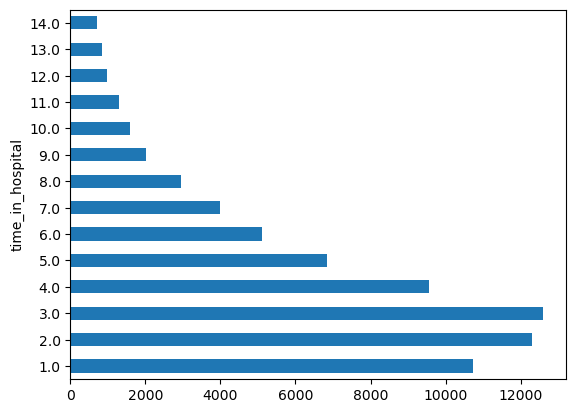

In [190]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6437
2.0     7386
3.0     7556
4.0     5734
5.0     4108
6.0     3064
7.0     2388
8.0     1769
9.0     1211
10.0     952
11.0     776
12.0     592
13.0     511
14.0     425
dtype: int64
Axes(0.125,0.11;0.775x0.77)


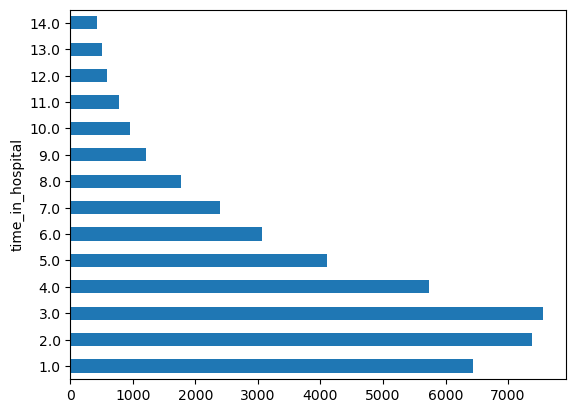

In [191]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2146
2.0     2462
3.0     2519
4.0     1911
5.0     1369
6.0     1021
7.0      796
8.0      590
9.0      404
10.0     318
11.0     259
12.0     197
13.0     170
14.0     141
dtype: int64
Axes(0.125,0.11;0.775x0.77)


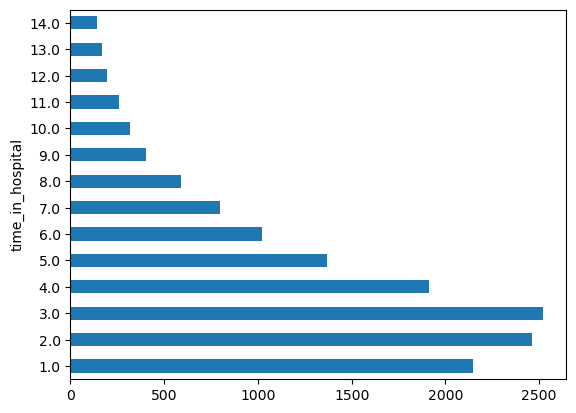

In [192]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

In [193]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)

#### Gender Distribution Accross Partitions

gender
Female    38023
Male      33492
dtype: int64
Axes(0.125,0.11;0.775x0.77)


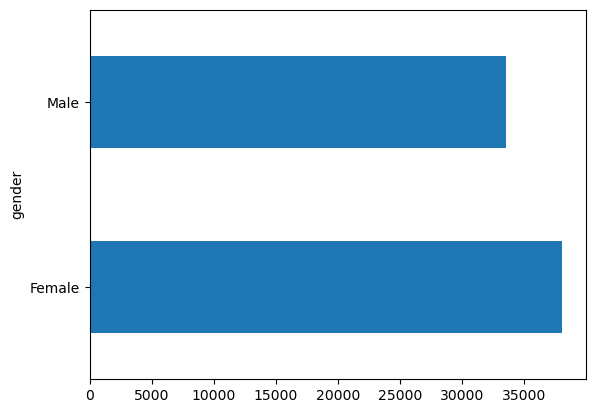

In [194]:
# Full dataset
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    22890
Male      20019
dtype: int64
Axes(0.125,0.11;0.775x0.77)


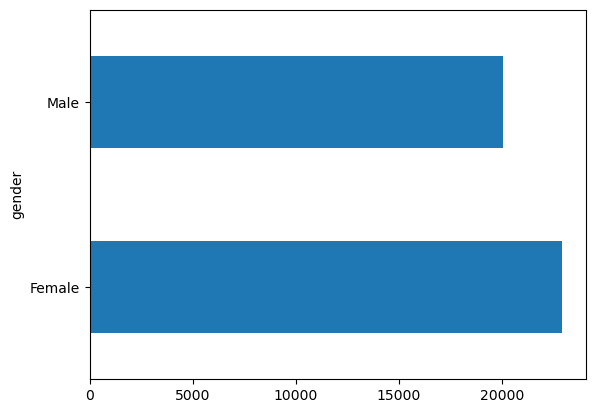

In [195]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    7502
Male      6801
dtype: int64
Axes(0.125,0.11;0.775x0.77)


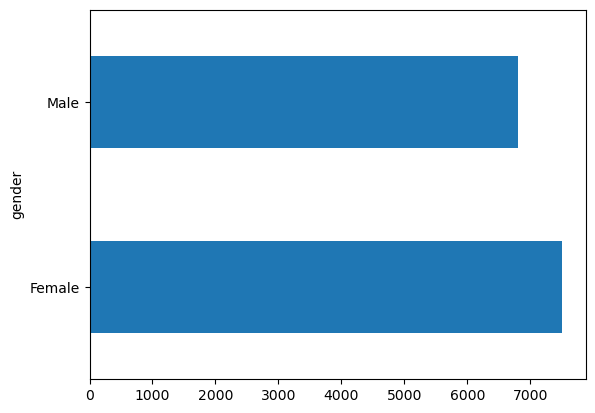

In [196]:
# Test partition
show_group_stats_viz(d_test, 'gender')

#### Age Distribution Accross Partitions

age
[0-10)        153
[10-20)       525
[20-30)      1111
[30-40)      2650
[40-50)      6756
[50-60)     12349
[60-70)     15907
[70-80)     18160
[80-90)     11864
[90-100)     2040
dtype: int64
Axes(0.125,0.11;0.775x0.77)


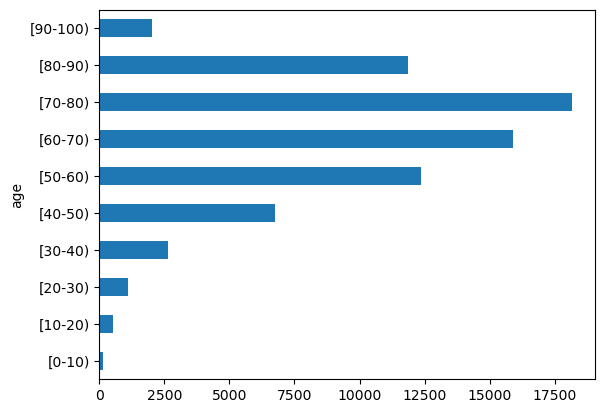

In [197]:
# Full dataset
show_group_stats_viz(patient_group_analysis_df, 'age')

age
[0-10)         96
[10-20)       302
[20-30)       665
[30-40)      1603
[40-50)      4036
[50-60)      7411
[60-70)      9493
[70-80)     10997
[80-90)      7096
[90-100)     1210
dtype: int64
Axes(0.125,0.11;0.775x0.77)


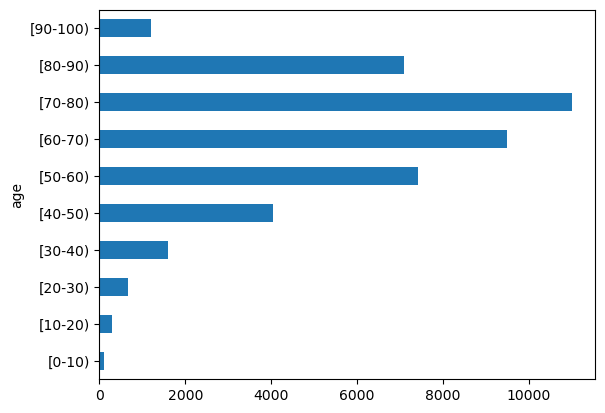

In [198]:
# train
show_group_stats_viz(d_train, 'age')

age
[0-10)        27
[10-20)      103
[20-30)      211
[30-40)      546
[40-50)     1389
[50-60)     2430
[60-70)     3200
[70-80)     3612
[80-90)     2381
[90-100)     404
dtype: int64
Axes(0.125,0.11;0.775x0.77)


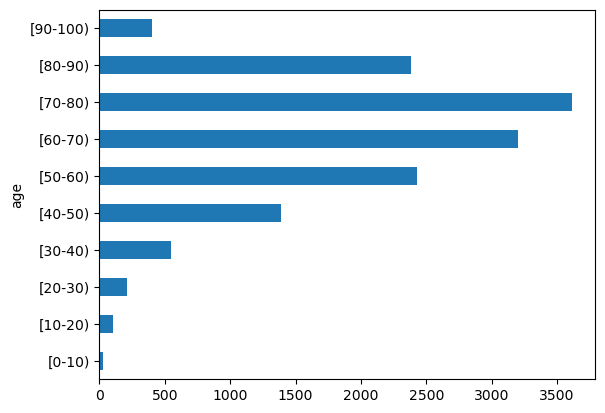

In [199]:
# val
show_group_stats_viz(d_val, 'age')

age
[0-10)        27
[10-20)      103
[20-30)      211
[30-40)      546
[40-50)     1389
[50-60)     2430
[60-70)     3200
[70-80)     3612
[80-90)     2381
[90-100)     404
dtype: int64
Axes(0.125,0.11;0.775x0.77)


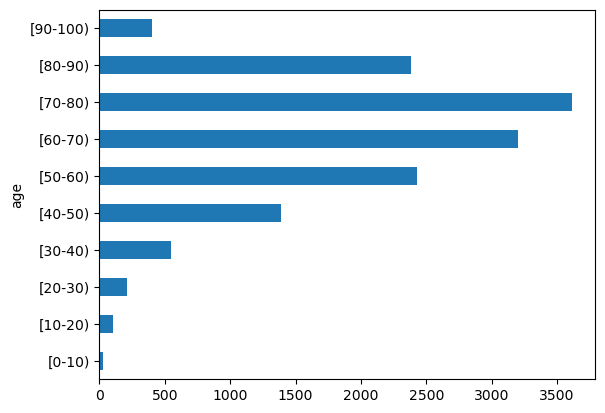

In [200]:
# test
show_group_stats_viz(d_val, 'age')

race
AfricanAmerican     2601
Asian                112
Caucasian          10662
Hispanic             302
Other                244
nan                  382
dtype: int64
Axes(0.125,0.11;0.775x0.77)


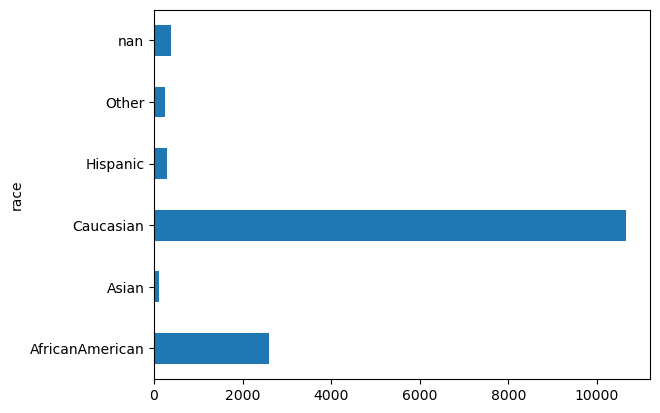

In [201]:
# test
show_group_stats_viz(d_val, 'race')

race
AfricanAmerican     2571
Asian                 86
Caucasian          10719
Hispanic             294
Other                230
nan                  403
dtype: int64
Axes(0.125,0.11;0.775x0.77)


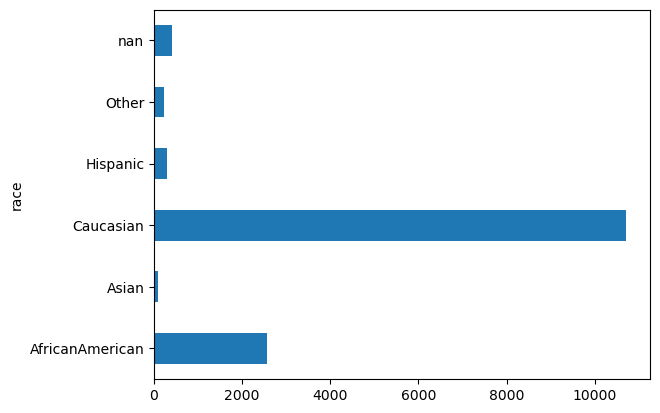

In [202]:
# test
show_group_stats_viz(d_test, 'race')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [51]:
d_train

,patient_nbr,num_procedures,time_in_hospital
57260,92132946,6,1
54834,93319488,0,2
58187,39316662,4,10
1556,5411169,0,2
8583,15974154,3,7
...,...,...,...
49732,64538856,0,2
70382,27672147,0,10
8739,97969212,0,3
21895,3399831,0,4


In [52]:
for df in (d_train, d_val, d_test):
    df.drop("patient_nbr", inplace=True, axis=1)

In [53]:
d_train.shape

(42910, 2)

In [54]:
d_val.shape

(14304, 2)

In [207]:
d_test.shape

(14303, 40)

In [56]:
d_train.head()

,num_procedures,time_in_hospital
57260,6,1
54834,0,2
58187,4,10
1556,0,2
8583,3,7


In [57]:
from utils import df_to_dataset

# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

2023-09-07 11:10:30.714596: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-09-07 11:10:30.714618: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-09-07 11:10:30.714626: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-09-07 11:10:30.714660: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-07 11:10:30.714678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [58]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
diabetes_batch

{'num_procedures': <tf.Tensor: shape=(128,), dtype=int64, numpy=
 array([1, 0, 1, 1, 1, 4, 1, 2, 0, 0, 1, 0, 0, 0, 2, 3, 0, 0, 1, 0, 6, 5,
        0, 0, 0, 1, 6, 6, 2, 0, 4, 6, 3, 5, 0, 0, 0, 0, 1, 1, 0, 3, 0, 1,
        0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 6,
        2, 0, 0, 1, 5, 1, 1, 0, 0, 6, 0, 0, 0, 4, 5, 2, 0, 1, 2, 1, 2, 2,
        6, 0, 3, 3, 0, 1, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 2, 5, 5, 0,
        0, 4, 2, 1, 0, 0, 5, 1, 1, 5, 0, 5, 2, 0, 0, 3, 1, 1])>}

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [210]:
from utils import build_vocab_files

vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

In [211]:
vocab_file_list[0]

'./diabetes_vocab/primary_diagnosis_code_vocab.txt'

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [212]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
INFO:tensorflow:vocabulary_size = 648 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.
INFO:tensorflow:vocabulary_size = 68 in medical_specialty is inferred from the number of elements in the vocabulary_file ./diabetes_voca

In [243]:
from utils import demo

test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_vocab.txt', vocabulary_size=648, num_oov_buckets=1, dtype=tf.string, default_value=-1, file_format=None))


ValueError: Exception encountered when calling layer 'dense_features_7' (type DenseFeatures).

Feature primary_diagnosis_code is not in features dictionary.

Call arguments received by layer 'dense_features_7' (type DenseFeatures):
  • features={'num_lab_procedures': 'tf.Tensor(shape=(128,), dtype=int64)'}
  • cols_to_output_tensors=None
  • training=None

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [62]:
from student_utils import create_tf_numeric_feature

def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [65]:
student_numerical_col_list = ["num_procedures"]
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [67]:
from utils import demo
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x29c262e60>, mean=1.3991610347238406, std=1.737881702983478))

tf.Tensor(
[[ 0.]
 [-1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 0.]
 [ 1.]
 [-1.]
 [-1.]
 [ 0.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 2.]
 [-1.]
 [-1.]
 [ 0.]
 [-1.]
 [ 5.]
 [ 4.]
 [-1.]
 [-1.]
 [-1.]
 [ 0.]
 [ 5.]
 [ 5.]
 [ 1.]
 [-1.]
 [ 3.]
 [ 5.]
 [ 2.]
 [ 4.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 2.]
 [-1.]
 [ 0.]
 [-1.]
 [ 3.]
 [-1.]
 [ 2.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 5.]
 [ 1.]
 [-1.]
 [-1.]
 [ 0.]
 [ 4.]
 [ 0.]
 [ 0.]
 [-1.]
 [-1.]
 [ 5.]
 [-1.]
 [-1.]
 [-1.]
 [ 3.]
 [ 4.]
 [ 1.]
 [-1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 5.]
 [-1.]
 [ 2.]
 [ 2.]
 [-1.]
 [ 0.]
 [-1.]
 [ 0.]
 [-1.]
 [ 2.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 0.]
 [-

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[ 0.],
       [-1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 3.],
       [ 0.],
       [ 1.],
       [-1.],
       [-1.],
       [ 0.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 2.],
       [-1.],
       [-1.],
       [ 0.],
       [-1.],
       [ 5.],
       [ 4.],
       [-1.],
       [-1.],
       [-1.],
       [ 0.],
       [ 5.],
       [ 5.],
       [ 1.],
       [-1.],
       [ 3.],
       [ 5.],
       [ 2.],
       [ 4.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 0.],
       [ 0.],
       [-1.],
       [ 2.],
       [-1.],
       [ 0.],
       [-1.],
       [ 3.],
       [-1.],
       [ 2.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 5.],
       [ 1.],
       [-1.]

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [68]:
tf_cont_col_list

[NumericColumn(key='num_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x29c262e60>, mean=1.3991610347238406, std=1.737881702983478))]

In [69]:
# claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_columns = tf_cont_col_list[0]
claim_feature_layer = keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [70]:
from utils import posterior_mean_field, prior_trainable

def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [72]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

Epoch 1/10


2023-09-07 11:19:18.481939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


336/336 [==============================] - ETA: 0s - loss: -29.2526 - mse: 10.9009

2023-09-07 11:19:23.203932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


336/336 [==============================] - 6s 15ms/step - loss: -29.2526 - mse: 10.9009 - val_loss: -60.8139 - val_mse: 9.7562
Epoch 2/10
336/336 [==============================] - 5s 14ms/step - loss: -82.6055 - mse: 9.4208 - val_loss: -100.5286 - val_mse: 8.9500
Epoch 3/10
336/336 [==============================] - 5s 14ms/step - loss: -113.0980 - mse: 9.5451 - val_loss: -125.5494 - val_mse: 9.1972
Epoch 4/10
336/336 [==============================] - 5s 13ms/step - loss: -135.6196 - mse: 9.5426 - val_loss: -145.1826 - val_mse: 9.9868
Epoch 5/10
336/336 [==============================] - 5s 14ms/step - loss: -154.3835 - mse: 9.8397 - val_loss: -163.4148 - val_mse: 9.6000


## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [74]:
d_train

,num_procedures,time_in_hospital
57260,6,1
54834,0,2
58187,4,10
1556,0,2
8583,3,7
...,...,...
49732,0,2
70382,0,10
8739,0,3
21895,0,4


In [75]:
# feature_list = student_categorical_col_list + student_numerical_col_list
feature_list = ["num_procedures"]
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

 23/112 [=====>........................] - ETA: 0s

2023-09-07 11:21:02.807779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


112/112 [==============================] - 1s 4ms/step


In [77]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [78]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [79]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,197.791107,3,13.652547,0.382243
1,-448.899139,4,96.545067,0.720012
2,200.104630,3,33.178146,0.751182
3,-124.257439,3,13.652547,0.382243
4,199.940994,2,96.545067,0.720012


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [80]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [81]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

KeyError: 'race'

In [ ]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [ ]:
# AUC, F1, precision and recall
# Summary

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [ ]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [ ]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [ ]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

In [ ]:
# Reference group fairness plot